# 네이버 영화 리뷰

###  [Naver sentiment movie corpus](https://github.com/e9t/nsmc) 사용

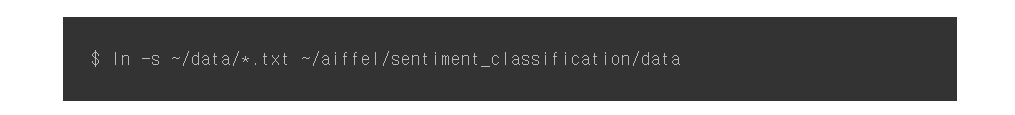

### 1) 데이터 준비와 확인

#### gensim을 실행하기 위해 처음부터 확인

In [1]:
# gensim 패키지 버전 알아보기

import gensim
gensim.__version__

'3.8.3'

In [ ]:
#!pip install --upgrade gensim==3.8.3 

In [2]:
import pandas as pd
import numpy as np
import os

import re
from konlpy.tag import Okt

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

import urllib.request # URL을 열기 위한 확장 가능한 라이브러리

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from collections import Counter

In [3]:
# 데이터를 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')


In [4]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
train_data.head()

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
test_data.head()

테스트용 리뷰 개수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2) 데이터로더 구성

#### 전혀 가공되지 않은 텍스트 파일을 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작

### data_loader 안에서는 수행할 것들
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

### data_loader() - 훈련,테스트, 정답, 단어사전 반환 - Okt형태소 분석기 사용

In [6]:

okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000): 
    
    # 훈련 데이터 전철리
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 데이터 제거   
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True) # 정규 표현식으로 한글, 공백 외 문자 제거
    train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)    # white space 데이터를 empty value로 변경
    train_data['document'].replace('', np.nan, inplace=True)    # empty value를 Null 값으로 변경
    train_data = train_data.dropna(how = 'any')      # Null 샘플 제거

   
    # 테스트 데이터 전처리 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
    test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) 
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how = 'any')   
    
            
    # 토큰화, 불용어 제거한 단어 리스트
    X_train = []
    for sentence in tqdm(train_data['document']):
        temp_X = okt.morphs(sentence, stem=True) # 형태소 분석
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in tqdm(test_data['document']):
        temp_X = okt.morphs(sentence, stem=True) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    


    # 단어사전 만들기
    words = np.concatenate(X_train).tolist()     # 한 줄짜리 리스트 만들기
    counter = Counter(words)                     # {단어: 출현 수} 딕셔너리 반환
    counter = counter.most_common(10000-4)       # 출현수가 많은 것에서 9996개 리스트 반환
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # 원소가 단어인 10000개의 리스트 
    word_to_index = {word:index for index, word in enumerate(vocab)}  # {단어:인덱스} 단어사전
      
        
    # 입력 문자가 단어사전에 있으면 단어사전 인덱스로 변환, 없으면 '<UNK>'의 인덱스를 반환하는 함수        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
      
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print(f"훈련 데이터의 개수 : {len(X_train)}, 테스트 데이터의 개수 : {len(X_test)}")

100%|██████████| 48852/48852 [02:51<00:00, 284.19it/s]


훈련 데이터의 개수 : 145393, 테스트 데이터의 개수 : 48852


## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
# 빈 리스트 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print(f"훈련데이터 개수 : {len(X_train)}, 정답 개수 : {len(y_train)}")
print(f"테스트 데이터 개수 : {len(X_test)}, 정답 개수 : {len(y_test)}")

훈련데이터 개수 : 145380, 정답 개수 : 145380
테스트 데이터 개수 : 48850, 정답 개수 : 48850


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


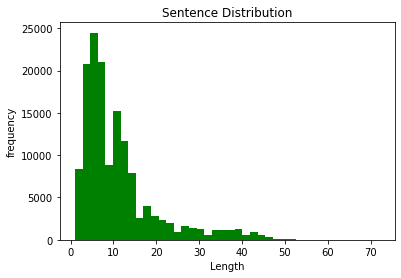

In [8]:
# 문장의 분포 구하기
train_len = []
for i in X_train:
    train_len.append(len(i))
    
plt.hist(x=train_len, bins=40, color="green")
plt.xlabel('Length')
plt.ylabel('frequency')
plt.title('Sentence Distribution')
plt.show()

In [9]:
# 표준편차를 이용해 문장의 최대 길이 구하기

max_len = int(np.mean(train_len) + np.std(train_len)*2)
print(f"문장의 최대길이 : {max(train_len)}")
print(f"문장의 평균길이 : {np.mean(train_len)}")
print(f"입력문장의 최대길이 : {max_len}")

문장의 최대길이 : 72
문장의 평균길이 : 11.002187371027652
입력문장의 최대길이 : 29


### 문장 패딩 추가

In [10]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=max_len)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=max_len)

print(X_train.shape)
print(y_train.shape)

(145380, 29)
(145380,)


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val,  Y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=2022, stratify=y_train)

print(f"훈련데이터 개수 : {len(x_train)}, 정답 개수 : {len(Y_train)}")
print(f"검증 데이터 개수 : {len(x_val)}, 정답 개수 : {len(y_val)}")

훈련데이터 개수 : 116304, 정답 개수 : 116304
검증 데이터 개수 : 29076, 정답 개수 : 29076


## 4) 모델 구성 및 validation set 구성 - 그래프도 같이...
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요

### 한글 Word2Vec embedding 사용하기 위해 vector_dim 미리 조정

### 1. GlobalMaxPooling1D

In [16]:
# GlobalMaxPooling1D 모델
vocab_size = 10000    
word_vector_dim = 200  

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(256, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

### 학습

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-conv1d.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)             
epochs=10 

hist = model.fit(x_train, Y_train, epochs=epochs, validation_data=(x_val, y_val), 
                 verbose=1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
3635/3635 [==============================] - 20s 5ms/step - loss: 0.3957 - accuracy: 0.8216 - val_loss: 0.3493 - val_accuracy: 0.8452
Epoch 2/10
3635/3635 [==============================] - 19s 5ms/step - loss: 0.3048 - accuracy: 0.8709 - val_loss: 0.3538 - val_accuracy: 0.8433
Epoch 3/10
3635/3635 [==============================] - 19s 5ms/step - loss: 0.2385 - accuracy: 0.9024 - val_loss: 0.3814 - val_accuracy: 0.8424
Epoch 4/10
3635/3635 [==============================] - 19s 5ms/step - loss: 0.1745 - accuracy: 0.9328 - val_loss: 0.4457 - val_accuracy: 0.8375


In [18]:
# 저장한 모델 불러와서 테스트 데이터 정확도 구하기

model = keras.models.load_model('best-conv1d.h5')
model.evaluate(X_test, y_test, verbose=1)

1527/1527 [==============================] - 3s 2ms/step - loss: 0.4446 - accuracy: 0.8352


[0.44460660219192505, 0.8351688981056213]

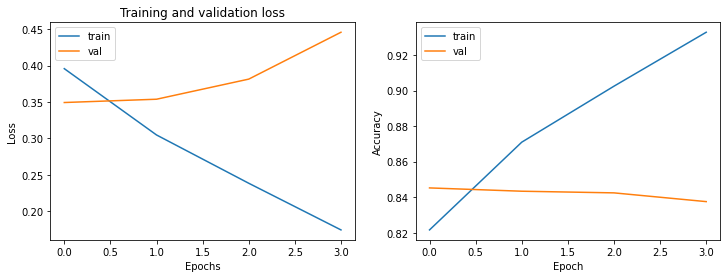

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim(0, 1)
plt.legend(['train', 'val'])

plt.show()

## 2. LSTM

In [20]:
vocab_size = 10000    
word_vector_dim = 200 

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

### LSTM 1 - optimizer='adam'

In [21]:
# optimizer='adam'
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTMadam-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)  

epochs=10 

hist2 = model2.fit(x_train, Y_train, epochs=epochs, validation_data=(x_val, y_val), 
                 verbose=1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
3635/3635 [==============================] - 30s 7ms/step - loss: 0.4003 - accuracy: 0.8159 - val_loss: 0.3500 - val_accuracy: 0.8474
Epoch 2/10
3635/3635 [==============================] - 25s 7ms/step - loss: 0.3152 - accuracy: 0.8628 - val_loss: 0.3496 - val_accuracy: 0.8499
Epoch 3/10
3635/3635 [==============================] - 25s 7ms/step - loss: 0.2790 - accuracy: 0.8814 - val_loss: 0.3481 - val_accuracy: 0.8503
Epoch 4/10
3635/3635 [==============================] - 25s 7ms/step - loss: 0.2476 - accuracy: 0.8960 - val_loss: 0.3791 - val_accuracy: 0.8486
Epoch 5/10
3635/3635 [==============================] - 25s 7ms/step - loss: 0.2212 - accuracy: 0.9098 - val_loss: 0.3947 - val_accuracy: 0.8463
Epoch 6/10
3635/3635 [==============================] - 25s 7ms/step - loss: 0.2002 - accuracy: 0.9189 - val_loss: 0.4276 - val_accuracy: 0.8365


In [22]:
# 저장한 모델 불러와서 테스트 데이터 정확도 구하기
best_LSTMadam = keras.models.load_model('best-LSTMadam-model.h5')
best_LSTMadam.evaluate(X_test, y_test)

1527/1527 [==============================] - 5s 3ms/step - loss: 0.4244 - accuracy: 0.8372


[0.4244008958339691, 0.8371545672416687]

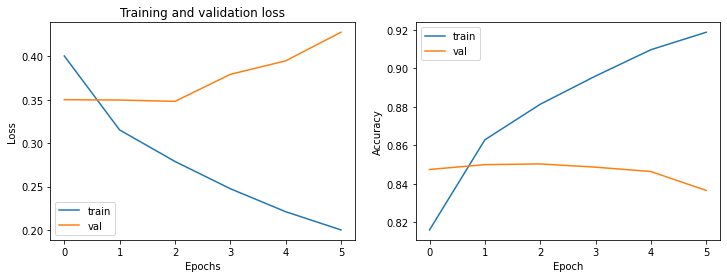

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.show()

### LSTM 2 - optimizer='rmsprop'

In [24]:
vocab_size = 10000    
word_vector_dim = 200 

model2_1 = keras.Sequential()
model2_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2_1.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model2_1.add(keras.layers.LSTM(8, dropout=0.3))
model2_1.add(keras.layers.Dense(1, activation='sigmoid'))

model2_1.summary()

rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model2_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTMrms-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)  

epochs=20 

hist2_1 = model2_1.fit(x_train, Y_train, epochs=epochs, validation_data=(x_val, y_val), 
                 verbose=1, callbacks=[checkpoint_cb, early_stopping_cb])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [25]:
# 저장한 모델 불러와서 테스트 데이터 정확도 구하기
best_LSTMrms = keras.models.load_model('best-LSTMrms-model.h5')
best_LSTMrms.evaluate(X_test, y_test)

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3492 - accuracy: 0.8514


[0.3491680920124054, 0.851381778717041]

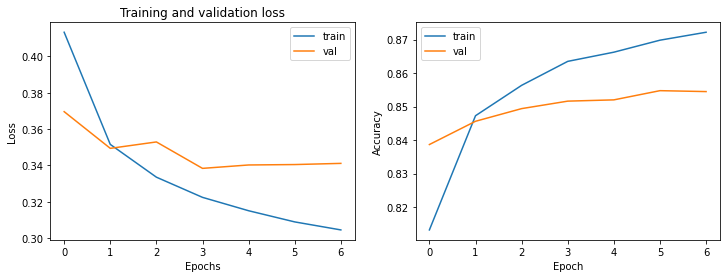

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist2_1.history['loss'])
plt.plot(hist2_1.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist2_1.history['accuracy'])
plt.plot(hist2_1.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.show()

### GRU1 - optimizer='adam'

In [27]:
vocab_size = 10000    
word_vector_dim = 200 

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GRU(8))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [28]:
# optimizer='adam'
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-GRUadam-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)  

epochs=20 

hist3 = model3.fit(x_train, Y_train, epochs=epochs, validation_data=(x_val, y_val), 
                 verbose=1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
3635/3635 [==============================] - 22s 5ms/step - loss: 0.4153 - accuracy: 0.7920 - val_loss: 0.3408 - val_accuracy: 0.8510
Epoch 2/20
3635/3635 [==============================] - 19s 5ms/step - loss: 0.2981 - accuracy: 0.8730 - val_loss: 0.3418 - val_accuracy: 0.8524
Epoch 3/20
3635/3635 [==============================] - 18s 5ms/step - loss: 0.2540 - accuracy: 0.8949 - val_loss: 0.3591 - val_accuracy: 0.8476
Epoch 4/20
3635/3635 [==============================] - 18s 5ms/step - loss: 0.2187 - accuracy: 0.9109 - val_loss: 0.3842 - val_accuracy: 0.8434


In [29]:
# 저장한 모델 불러와서 테스트 데이터 정확도 구하기
best_GRUadam = keras.models.load_model('best-GRUadam-model.h5')
best_GRUadam.evaluate(X_test, y_test)

1527/1527 [==============================] - 4s 2ms/step - loss: 0.3899 - accuracy: 0.8409


[0.3898501992225647, 0.8408597707748413]

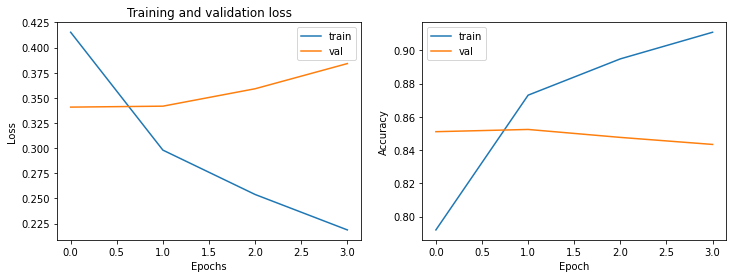

In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.show()

### GRU2 - optimizer='rmsprop'

In [31]:
vocab_size = 10000    
word_vector_dim = 200 

model3_2 = keras.Sequential()
model3_2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3_2.add(keras.layers.GRU(8))
model3_2.add(keras.layers.Dense(1, activation='sigmoid'))

model3_2.summary()

rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model3_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-GRUrms-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)  

epochs=20 

hist3_2 = model3_2.fit(x_train, Y_train, epochs=epochs, validation_data=(x_val, y_val), 
                 verbose=1, callbacks=[checkpoint_cb, early_stopping_cb])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         153856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         98432     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [32]:
# 저장한 모델 불러와서 테스트 데이터 정확도 구하기
best_GRUrms = keras.models.load_model('best-GRUrms-model.h5')
best_GRUrms.evaluate(X_test, y_test)

1527/1527 [==============================] - 4s 2ms/step - loss: 0.3492 - accuracy: 0.8506


[0.34919944405555725, 0.8505834341049194]

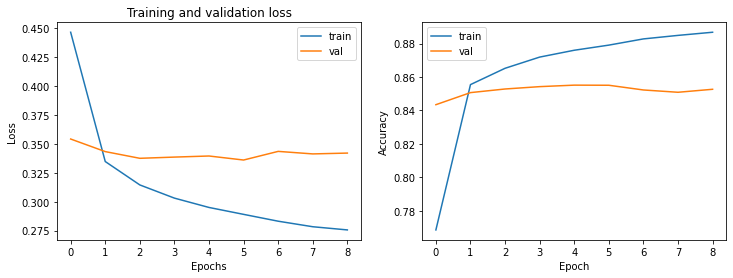

In [33]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist3_2.history['loss'])
plt.plot(hist3_2.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist3_2.history['accuracy'])
plt.plot(hist3_2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.show()

## 5) 학습된 Embedding 레이어 분석

### Word2Vec
- 구글에서 제공하는 사전학습된(Pretrained) 워드 임베딩 모델
- 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습
- 총 300만 개의 단어를 각각 300차원의 벡터로 표현한 것
- 사전학습된 임베딩을 활용하는 것이 유리한 이유는 전이학습 때문이다  

<br><br>
###  Google의 Word2Vec 모델 적용
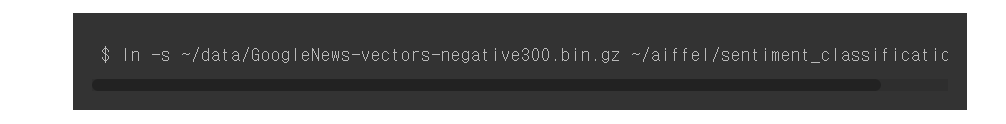
<br>
- 가장 많이 사용되는 **상위 100만 개만 limt으로 조건**을 주어 로딩

In [38]:
# 임베딩 레이어 변수 지정
embedding_layer = best_GRUrms.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 디코딩
index_to_word = {index:word for word, index in word_to_index.items()}

(10000, 200)


In [39]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [44]:
# gensim에서 제공하는 패키지를 이용해 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([ 0.12865296, -0.12707439,  0.19241278, -0.02668433, -0.24344192,
       -0.15033343, -0.35786834,  0.05616558,  0.25969452, -0.19187638,
       -0.01796622,  0.2393149 , -0.08569154,  0.10221565,  0.09729655,
       -0.22427876, -0.11201705, -0.04629279, -0.20619825, -0.00112662,
       -0.18428378,  0.16196501, -0.05508336, -0.19458903, -0.09196062,
        0.13015722, -0.0182563 , -0.11865455, -0.12929086,  0.13723807,
        0.03919182, -0.03261316, -0.15519087,  0.17404403,  0.16150123,
        0.27583492,  0.2680378 ,  0.08183642,  0.10097796,  0.08320767,
       -0.05156622, -0.07139601,  0.01958957, -0.1765012 ,  0.00493364,
        0.03020845, -0.10367075, -0.01316683, -0.17299888, -0.25647545,
       -0.2718321 ,  0.01755185, -0.29884022,  0.06193525, -0.04492911,
       -0.24644476,  0.2227944 ,  0.09804451, -0.09582014,  0.19701487,
       -0.17678417,  0.10582854,  0.0181387 ,  0.18360206, -0.00879993,
       -0.04675362, -0.21774493, -0.05676484,  0.17648722, -0.06

In [45]:
# gensim을 사용해 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인
word_vectors.similar_by_word("행복")

[('감독판', 0.8085969686508179),
 ('해학', 0.7921085357666016),
 ('굿굿굿', 0.7912741899490356),
 ('밋음', 0.7903404831886292),
 ('전율', 0.7897253036499023),
 ('강렬하다', 0.7870133519172668),
 ('드라마틱하다', 0.7837130427360535),
 ('스타트렉', 0.7825528383255005),
 ('흐', 0.7782420516014099),
 ('관해', 0.7782050967216492)]

## 6) 한국어 버전 Word2Vec Embedding
#### [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors)
-  적절한 ko.bin을 찾아 이용하세요. 그리고 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않습니다.

In [49]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec_ko = gensim.models.Word2Vec.load(word2vec_path)
vector_any = word2vec_ko['사랑']
vector_any.shape

/tmp/ipykernel_568/4208297916.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_any = word2vec_ko['사랑']


(200,)

In [59]:
word2vec_ko.wv.most_similar("선거")

[('총선거', 0.7462450265884399),
 ('총선', 0.7030401825904846),
 ('대선', 0.6811904907226562),
 ('투표', 0.6405338048934937),
 ('경선', 0.6404521465301514),
 ('개표', 0.6106421947479248),
 ('재선거', 0.6045101881027222),
 ('표결', 0.5645790100097656),
 ('의회', 0.5523425936698914),
 ('야권', 0.5519712567329407)]

In [61]:
vocab_size = 10000     # 단어 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim) # 사전학습된 임베딩 레이어의 차원 수 그대로 따라가는 것이 좋아요!

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 순서대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec_ko:
        embedding_matrix[i] = word2vec_ko[index_to_word[i]]

/tmp/ipykernel_568/2387564163.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec_ko:
/tmp/ipykernel_568/2387564163.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec_ko[index_to_word[i]]


### LSTM 2 - optimizer='rmsprop' 한글 Word2Vec 적용해보기

In [72]:
from tensorflow.keras.initializers import Constant


vocab_size = 10000    
word_vector_dim = 200 

model_lstmrms = keras.Sequential()
model_lstmrms.add(keras.layers.Embedding(vocab_size, word_vector_dim, 
                                    embeddings_initializer=Constant(embedding_matrix),   # 카피한 임베딩 활용
                                    input_shape=(None,)))
model_lstmrms.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model_lstmrms.add(keras.layers.LSTM(8, dropout=0.3))
model_lstmrms.add(keras.layers.Dense(1, activation='sigmoid'))

model_lstmrms.summary()

rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model_lstmrms.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTMrmsko-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)  

epochs=20 

hist_lstmrms = model_lstmrms.fit(x_train, Y_train, epochs=epochs, validation_data=(x_val, y_val), 
                 verbose=1, callbacks=[checkpoint_cb, early_stopping_cb])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 8)           6688      
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,007,241
Trainable params: 2,007,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3635/3635 [==============================] - 33s 8ms/step - loss: 0.5017 - accuracy: 0.7453 - val_loss: 0.3942 - val_accuracy: 0.8206
Epoch 2/20
3635/3635 [==============================] - 26s 7ms/step - loss: 0.3937 - accuracy: 0

In [73]:
# 저장한 모델 불러와서 테스트 데이터 정확도 구하기
best_LSTMrms = keras.models.load_model('best-LSTMrms-model.h5')
best_LSTMrms.evaluate(X_test, y_test)

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3563 - accuracy: 0.8484


[0.3562648594379425, 0.8483930230140686]

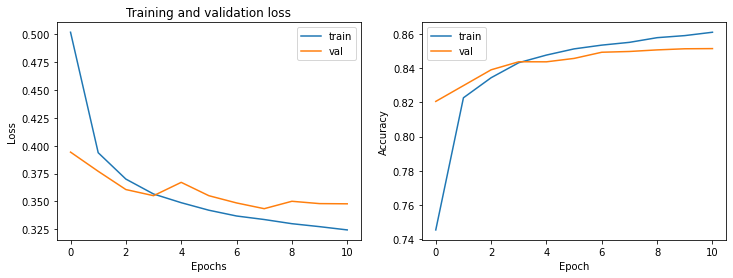

In [75]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist_lstmrms.history['loss'])
plt.plot(hist_lstmrms.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist_lstmrms.history['accuracy'])
plt.plot(hist_lstmrms.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.show()